<a href="https://colab.research.google.com/github/adikeshn/Insulin-Dosage-Model/blob/main/Glucose_Insulin_Model_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow as tf

# Data Preprocessing and cleanup

Fetching and setting up time series data



In [ ]:

df = pd.read_csv("FirstPatientData.csv")
df["Timestamp (YYYY-MM-DDThh:mm:ss)"] = pd.to_datetime(df["Timestamp (YYYY-MM-DDThh:mm:ss)"])

df = df[["Timestamp (YYYY-MM-DDThh:mm:ss)",
         "Glucose Value (mg/dL)",
         "Insulin Value (u)",
         "Event Subtype",
         "Carb Value (grams)"]]
df = df.rename(columns={"Timestamp (YYYY-MM-DDThh:mm:ss)": "Time", "Glucose Value (mg/dL)" : "Glucose", "Insulin Value (u)": "Insulin", "Carb Value (grams)": "Carbs"})

df = df.dropna(subset=["Time"])

df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute

df['Hour_sin'] = np.sin(2 * np.pi * (df['Hour'] / 24))
df['Hour_cos'] = np.cos(2 * np.pi * (df['Hour'] / 24))
df['Minute_sin'] = np.sin(2 * np.pi * (df['Minute'] / 60))
df['Minute_cos'] = np.cos(2 * np.pi * (df['Minute'] / 60))

df = df.drop(["Hour", "Minute", "Time"], axis = 1)


removing null and erroneous values

In [ ]:
df["Event Subtype"] = df["Event Subtype"].fillna("none")
df["Insulin"] = df["Insulin"].fillna(0)
df["Carbs"] = df["Carbs"].fillna(0)

df['Glucose'] = pd.to_numeric(df['Glucose'], errors='coerce')

df["Glucose"] = df["Glucose"].ffill()

Adding separate short/long column names

In [ ]:
df["Short-Acting"] = 0
df["Long-Acting"] = 0

for index, row in df.iterrows():
  if row["Event Subtype"] == "Long-Acting":
    df.loc[index, "Long-Acting"] = row["Insulin"]
  elif row["Event Subtype"] == "Fast-Acting":
    df.loc[index, "Short-Acting"] = row["Insulin"]

df = df.drop("Insulin", axis=1)
df = df.drop("Event Subtype", axis=1)
df_initial = df

Creating different types of dataset that only contains entries with non-zero insulin values or nonzero carb values

In [ ]:
df_resampled = df[::10]

df_0filtered = df.loc[((df["Carbs"] != 0) | (df["Short-Acting"] != 0) | (df["Long-Acting"] != 0))]
df_concat = pd.concat([df_0filtered, df_resampled])
df_concat = df_concat[~df_concat.index.duplicated(keep='first')]
print(df_initial.index)


Int64Index([   16,    17,    18,    19,    20,    21,    22,    23,    24,
               25,
            ...
            25153, 25154, 25155, 25156, 25157, 25158, 25159, 25160, 25161,
            25162],
           dtype='int64', length=25147)


Adding Next Glucose Column

In [ ]:
def createNextCols(df):
  df["Next Glucose"] = df["Glucose"].shift(-1).ffill()
  df['Next Hour_sin'] = df["Hour_sin"].shift(-1).ffill()
  df['Next Hour_cos'] = df["Hour_cos"].shift(-1).ffill()
  df['Next Minute_sin'] = df["Minute_sin"].shift(-1).ffill()
  df['Next Minute_cos'] = df["Minute_cos"].shift(-1).ffill()

createNextCols(df_initial)
createNextCols(df_0filtered)
createNextCols(df_concat)



<ipython-input-77-4265add75768>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Next Glucose"] = df["Glucose"].shift(-1).ffill()
<ipython-input-77-4265add75768>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Next Hour_sin'] = df["Hour_sin"].shift(-1).ffill()
<ipython-input-77-4265add75768>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

# Now we have 3 different datasets

df_initial: every entry of data

df_0filtered: all entries with values not equal to 0 for carbs, long-acting, or short-acting

df_concat: containing every 10th entry plus any entry that satisfies df_0filtered rule

<Axes: >

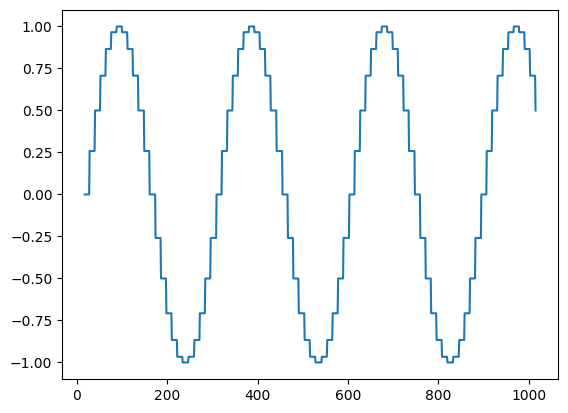

In [ ]:
df_initial["Hour_sin"][1:1000].plot()

In [ ]:
df_0filtered

,Glucose,Carbs,Hour_sin,Hour_cos,Minute_sin,Minute_cos,Short-Acting,Long-Acting,Next Glucose,Next Hour_sin,Next Hour_cos,Next Minute_sin,Next Minute_cos
142,105.0,0.0,5.000000e-01,-8.660254e-01,4.067366e-01,-9.135455e-01,0,20,134.0,1.224647e-16,-1.000000e+00,-1.000000e+00,-1.836970e-16
171,134.0,15.0,1.224647e-16,-1.000000e+00,-1.000000e+00,-1.836970e-16,0,0,180.0,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16
243,180.0,0.0,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16,15,0,179.0,-9.659258e-01,2.588190e-01,8.660254e-01,5.000000e-01
250,179.0,20.0,-9.659258e-01,2.588190e-01,8.660254e-01,5.000000e-01,0,0,186.0,-2.588190e-01,9.659258e-01,-6.691306e-01,-7.431448e-01
304,186.0,0.0,-2.588190e-01,9.659258e-01,-6.691306e-01,-7.431448e-01,0,20,93.0,5.000000e-01,-8.660254e-01,-9.510565e-01,-3.090170e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24849,113.0,15.0,-2.588190e-01,-9.659258e-01,1.045285e-01,-9.945219e-01,0,0,138.0,-7.071068e-01,7.071068e-01,-9.781476e-01,2.079117e-01
24949,138.0,20.0,-7.071068e-01,7.071068e-01,-9.781476e-01,2.079117e-01,0,0,113.0,-2.588190e-01,9.659258e-01,-5.000000e-01,8.660254e-01
24976,113.0,0.0,-2.588190e-01,9.659258e-01,-5.000000e-01,8.660254e-01,0,20,114.0,8.660254e-01,-5.000000e-01,-1.045285e-01,9.945219e-01
25086,114.0,0.0,8.660254e-01,-5.000000e-01,-1.045285e-01,9.945219e-01,0,20,117.0,5.000000e-01,-8.660254e-01,1.224647e-16,-1.000000e+00


In [ ]:
df_resampled

,Glucose,Carbs,Hour_sin,Hour_cos,Minute_sin,Minute_cos,Short-Acting,Long-Acting
16,196.0,0.0,0.000000e+00,1.000000,0.000000e+00,1.000000,0,0
26,193.0,0.0,0.000000e+00,1.000000,-8.660254e-01,0.500000,0,0
36,163.0,0.0,2.588190e-01,0.965926,-8.660254e-01,-0.500000,0,0
46,151.0,0.0,5.000000e-01,0.866025,1.224647e-16,-1.000000,0,0
56,159.0,0.0,7.071068e-01,0.707107,8.660254e-01,-0.500000,0,0
...,...,...,...,...,...,...,...,...
25116,134.0,0.0,2.588190e-01,-0.965926,7.431448e-01,-0.669131,0,0
25126,144.0,0.0,1.224647e-16,-1.000000,9.510565e-01,0.309017,0,0
25136,142.0,0.0,-2.588190e-01,-0.965926,2.079117e-01,0.978148,0,0
25146,114.0,0.0,-2.588190e-01,-0.965926,-7.431448e-01,0.669131,0,0


# Convert Data into labels and outputs that the model can use




Set up TensorFlow and start the RNN

In [ ]:
import numpy as np

Create function to make an array with all previous values beforehand

In [ ]:
def previousData(data):
    X, y = [], []
    for i in range(0, len(data)):
        sequence = (data.iloc[:i]).to_numpy() # Get all data up to the current point
        target = np.array([data.iloc[i]["Short-Acting"], data.iloc[i]["Long-Acting"]]) # Current point to predict
        X.append(sequence)
        y.append(target)
    return np.array(X, dtype=object), np.array(y)

In [ ]:
#X, y = previousData(df_0filtered)
X, y = previousData(df_0filtered)


# Creating the LSTM Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.optimizers import Adam

In [ ]:
num_features = df_initial.shape[1]
input_shape = ( None, num_features)
inputs = Input(shape=input_shape)
lstm_output = LSTM(64)(inputs)
dense = Dense(32, activation="relu")(lstm_output)
output_short_acting = Dense(1, activation='linear', name='short_acting_output')(dense)
output_long_acting = Dense(1, activation='linear', name='long_acting_output')(dense)

model = Model(inputs=inputs, outputs=[output_short_acting, output_long_acting], name="GoofedUpModel")

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')



# Print the model summary
model.summary()

Model: "GoofedUpModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, None, 13)]           0         []                            
                                                                                                  
 lstm_7 (LSTM)               (None, 64)                   19968     ['input_8[0][0]']             
                                                                                                  
 dense_3 (Dense)             (None, 32)                   2080      ['lstm_7[0][0]']              
                                                                                                  
 short_acting_output (Dense  (None, 1)                    33        ['dense_3[0][0]']             
 )                                                                                    

In [ ]:
X = tf.ragged.constant(X)
y = tf.convert_to_tensor(y)

In [ ]:
num_samples = X.shape[0]
train_size = int(num_samples * 0.7)

X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:]
y_val = y[train_size:]
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/100
11/11 [==============================] - 11s 1s/step - loss: 98.8998 - short_acting_output_loss: 49.4553 - long_acting_output_loss: 49.4446 - val_loss: 0.1738 - val_short_acting_output_loss: 0.0748 - val_long_acting_output_loss: 0.0990
Epoch 2/100
11/11 [==============================] - 12s 1s/step - loss: 98.7780 - short_acting_output_loss: 49.3894 - long_acting_output_loss: 49.3886 - val_loss: 0.1999 - val_short_acting_output_loss: 0.0905 - val_long_acting_output_loss: 0.1094
Epoch 3/100
11/11 [==============================] - 12s 1s/step - loss: 99.1592 - short_acting_output_loss: 49.5651 - long_acting_output_loss: 49.5940 - val_loss: 0.1433 - val_short_acting_output_loss: 0.0832 - val_long_acting_output_loss: 0.0601
Epoch 4/100
11/11 [==============================] - 10s 1s/step - loss: 98.9616 - short_acting_output_loss: 49.4810 - long_acting_output_loss: 49.4806 - val_loss: 0.1630 - val_short_acting_output_loss: 0.0890 - val_long_acting_output_loss: 0.0739
Epoch 5/

KeyboardInterrupt: 

In [ ]:
x = model.predict(X_val[0:1])

# Print the predicted insulin dosages
print("Predicted Insulin Dosages:")


1/1 [==============================] - 0s 31ms/step
Predicted Insulin Dosages:


In [ ]:
print(x[0][0])
print(X_val[0][0])

[9.735185]
tf.Tensor(
[ 1.05000000e+02  0.00000000e+00  5.00000000e-01 -8.66025404e-01
  4.06736643e-01 -9.13545458e-01  0.00000000e+00  2.00000000e+01
  1.34000000e+02  1.22464680e-16 -1.00000000e+00 -1.00000000e+00
 -1.83697020e-16], shape=(13,), dtype=float64)
